In [1]:
# Install ReadVTK with: import Pkg; Pkg.add("ReadVTK")
using ReadVTK

# Loading VTI files into Julia

function read_vti( filename, typ=Float64 )
    
    vtk_file       = VTKFile( filename )
    vtk_cell_data  = get_cell_data(vtk_file)
    vtk_data_array = vtk_cell_data["intensities"]
    data_size, _   = ReadVTK.get_wholeextent(vtk_data_array.vtk_file.xml_file, false)
    vtk_data       = get_data( vtk_data_array ); 
    data_reshaped  = reshape(vtk_data, (data_size .- 1 )...); 
    return typ.( data_reshaped ) 
end


read_vti (generic function with 2 methods)

In [2]:
# Extract the single i-th layer from vti files and save the image data
# over all time points locally into a .h5 file.

using HDF5

function extract_layer(folder_path::String, i::Int64)
    
    # variable folder_path should be in type string.
    n_files = length(readdir(folder_path))
    
    # Storing data from a single layer over time in an Array. 
    layer_data = Matrix{Float64}[]
    
    #for file in readdir(folder_path)
    for t in 0:n_files-1
        # file is in type String. Open the file.
        #cell_data = read_vti(folder_path * "/" * file)
        cell_data = read_vti(folder_path* "/tp"* string(t)* ".vti")
        # Choose the i-th layer from the cell data and append it 
        # to layer_data.
        push!(layer_data, cell_data[:,:,i])
    end
    
    # Convert the layer_data to 3D array structure
    # (width, height, timepoint) dimensional.
    l_data = reduce((x,y) -> cat(x,y,dims=3), layer_data)

    # Save the data in .h5 file with package HDF5.jl
    h5open("headon_layer_"*string(i)*".h5", "w") do file
    write(file, "data", l_data)  
    end

end

extract_layer (generic function with 1 method)

In [3]:
extract_layer("/media/shared/Headon_data/data/single_channel/video_1", 2)

In [2]:
# Read h5 file in which image data is saved. 
using HDF5
function read_h5(folder_path::String)
    h5open(folder_path, "r") do file
        read(file, "data")
    end
end


read_h5 (generic function with 1 method)

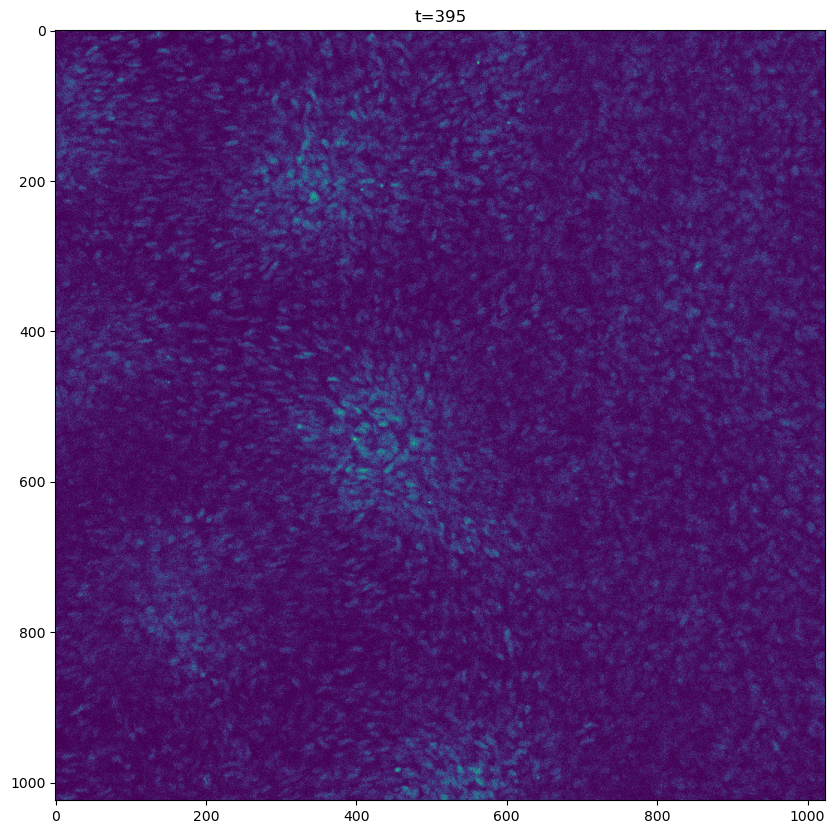

In [7]:
# Function for presenting single layer dynamics over time as .gif

using PyCall
@pyimport matplotlib.animation as anim
using PyPlot
using Images

# Update function for video.

# Making video.
#function single_layer_dyn(folder_path::String, filename::String)
    # Read the data saved in .h5 file.
data = read_h5("headon_layer_5.h5")

fig = PyPlot.figure(figsize=(10, 10))

function make_frame(i)
    PyPlot.clf()
    PyPlot.title("t=$(i+1)")
    imshow(Float64.(Gray.(data[:, :, i+1])))
end

myanim = anim.FuncAnimation(fig, make_frame, frames=size(data, 3), 
                                interval=300, repeat=false, blit=false)
myanim[:save]("headon_layer_5.gif", writer="pillow")
#end

In [5]:
#=
using PyCall
@pyimport matplotlib.animation as anim
using PyPlot
using Images
using HDF5

function make_frame(i, data)
    imshow(Float64.(Gray.(data[:, :, i+1])))
end

function single_layer_dyn(open_filename::String, save_filename::String)
    data = read_h5(open_filename*".h5")
    
    fig = PyPlot.figure(figsize=(10, 10))
    
    myanim = anim.FuncAnimation(fig, make_frame, frames=size(data, 3)-1, 
                                interval=200, repeat=false, blit=false)
    myanim[:save](save_filename*".gif", writer="pillow")
end
=#
    

In [6]:
#=
single_layer_dyn("headon_layer_5", "headon_layer_5")
=#

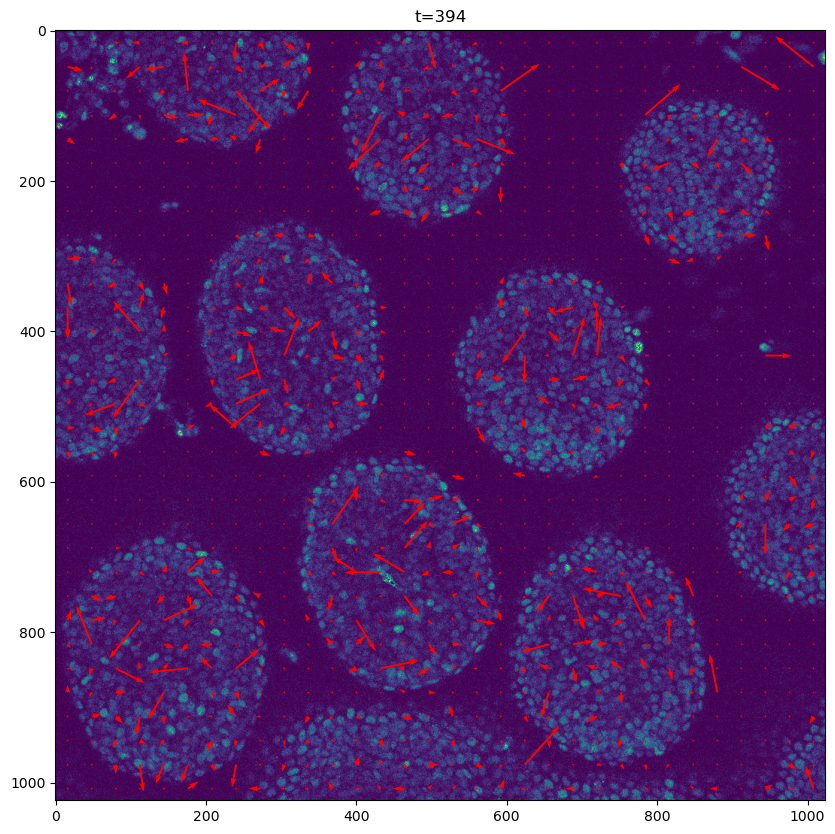

In [7]:
# Function for PIV vector fields. (Causion the orientation y-axis!)

using PyCall
@pyimport matplotlib.animation as anim
using PyPlot
using Images
using multi_quickPIV
using ImageBinarization
using ImageAnalysis

# intensity of a subregion. 
function integralArea( intArr::Matrix{Float64}, TL, BR)
    area = intArr[BR[1],BR[2]] - intArr[BR[1],TL[2]] - intArr[TL[1],BR[2]] + intArr[TL[1],TL[2]]
    return area
end


l_data = read_h5("headon_layer_2.h5")

#params = multi_quickPIV.setPIVParameters() 
params = multi_quickPIV.setPIVParameters(interSize = (32, 32))
IA_size = multi_quickPIV._isize(params)[1:2]
IA_step = multi_quickPIV._step(params)[1:2]

fig = PyPlot.figure(figsize=(10, 10))

function make_frame(i) # Due to Python function i begins with 0!
    
    PyPlot.clf()

    # Taking images.
    img1 = Float64.(Gray.(l_data[:, :, i+1]))
    img2 = Float64.(Gray.(l_data[:, :, i+2]))

    # Applying filtering on the images.
    img1_b = binarize(img1, Polysegment())
    img2_b = binarize(img2, Polysegment())
    
    VF, SN = multi_quickPIV.PIV(img1_b, img2_b, params)
    
    U = VF[ 1, :, : ]
    V = VF[ 2, :, : ]
    
    xgrid = [ (x-1)*IA_step[2] + div(IA_size[2],2) for y in 1:size(U,1), x in 1:size(U,2) ] 
    ygrid = [ (y-1)*IA_step[1] + div(IA_size[1],2) for y in 1:size(U,1), x in 1:size(U,2) ]

    # Setting arrows on blank IA to be zero.
    sum_img = ImageAnalysis.integralArray(img1_b, typ = Float64, fun = (x) -> (x))
    width = Integer(IA_size[1]/2)
    w = size(img1_b)[1]
    h = size(img1_b)[2]
    
    for x in 1:size(U)[1]
        for y in 1:size(U)[2]

            col = xgrid[x, y]
            row = ygrid[x, y]

            TL = max(1, row-width), max(1, col-width)
            BR = min(h, row+width), min(w, col+width)

            if integralArea(sum_img, TL, BR) <= 3
                U[x, y] = 0
                V[x, y] = 0
            end
        end
    end

    imshow(img1) # With original images as background.
    #imshow(img1_f) # With filtered images as background.
    PyPlot.title("t=$(i+1)")
    PyPlot.quiver( xgrid, ygrid, V, -1 .* U, color="red", scale=200 )
    #PyPlot.quiver( xgrid, ygrid, U, V , color="red", scale=200)
end

myanim = anim.FuncAnimation(fig, make_frame, frames=size(l_data,3)-1, 
                            interval=300)
myanim[:save]("headon_2_v1_32.gif", writer="pillow")


In [2]:
#slices = read_h5("headon_layer_2_v1.h5")

1024×1024×395 Array{Float64, 3}:
[:, :, 1] =
  20.0  198.0  780.0    81.0   32.0    49.0  …    48.0   74.0   40.0    60.0
  30.0   19.0   44.0    55.0   37.0    44.0       21.0   13.0   28.0   703.0
  31.0  113.0   63.0    43.0  349.0   106.0       35.0   40.0   51.0    38.0
 552.0   26.0   14.0    26.0   34.0    29.0      107.0    8.0   20.0    48.0
  47.0  486.0   94.0    34.0   48.0   924.0       66.0  492.0   60.0    23.0
  36.0  662.0  179.0   200.0   46.0    44.0  …    14.0  503.0   25.0    31.0
  52.0   54.0   61.0    54.0  403.0    43.0       56.0   72.0   49.0   310.0
  40.0   38.0  114.0    30.0   85.0    29.0       41.0  103.0  345.0    29.0
 166.0   29.0  359.0    58.0  671.0   374.0       60.0   53.0   63.0    50.0
 103.0   42.0  473.0    66.0   30.0    20.0      353.0   39.0  431.0   148.0
  48.0   39.0   62.0   118.0   36.0    61.0  …    72.0   42.0  487.0   660.0
 569.0   39.0   68.0    35.0   91.0    81.0      287.0   51.0   76.0    61.0
 596.0   22.0   43.0   237.0   

In [3]:
using PyCall
@pyimport matplotlib.animation as anim
using PyPlot
using Images
#using multi_quickPIV
include("multi_quickPIV/src/multi_quickPIV.jl") # Apply the local version of multiquick_PIV -> perhaps different!
using ImageBinarization
using ImageAnalysis
include("multiscale_multistep_filter.jl")
using Statistics

In [4]:
# Parameters for multiscale filtering.
grid_sizes = ( (7,7), )
scales     = ( ((4,4),(2,2)), ) 
steps      = ( ((1,1),(4,4)), ) 

# Parameters for mask
Δ_low = 2000 # 4000 expected intensity difference between background and signal
#Δ_up = 30000
α = 1.5  # 1.0 - 2.0

# Parameters of quick_PIV
pivparams = multi_quickPIV.setPIVParameters( interSize=(32,32), 
            step=(16,16), threshold=0.2, filtFun=(M)->(sum(M)/length(M)) )
IA = multi_quickPIV._isize(pivparams)
ST = multi_quickPIV._step(pivparams)

# Parameters for postprocessing
std_factor = 3
dyn_factor = 0.2
function postprocess(M::Matrix{Float32})
    meanM = Statistics.mean(M)
    stdM = Statistics.std(M)
    std_factor = dyn_factor * maximum( (M .- meanM) ) # dynamic std_factor depending on dyn_factor.
    mask_M = M .<= meanM + std_factor * stdM  
    M .*= mask_M
    return M
end

# Pick the slice.
slices = read_h5("headon_layer_2_v1.h5")

1024×1024×395 Array{Float64, 3}:
[:, :, 1] =
  20.0  198.0  780.0    81.0   32.0    49.0  …    48.0   74.0   40.0    60.0
  30.0   19.0   44.0    55.0   37.0    44.0       21.0   13.0   28.0   703.0
  31.0  113.0   63.0    43.0  349.0   106.0       35.0   40.0   51.0    38.0
 552.0   26.0   14.0    26.0   34.0    29.0      107.0    8.0   20.0    48.0
  47.0  486.0   94.0    34.0   48.0   924.0       66.0  492.0   60.0    23.0
  36.0  662.0  179.0   200.0   46.0    44.0  …    14.0  503.0   25.0    31.0
  52.0   54.0   61.0    54.0  403.0    43.0       56.0   72.0   49.0   310.0
  40.0   38.0  114.0    30.0   85.0    29.0       41.0  103.0  345.0    29.0
 166.0   29.0  359.0    58.0  671.0   374.0       60.0   53.0   63.0    50.0
 103.0   42.0  473.0    66.0   30.0    20.0      353.0   39.0  431.0   148.0
  48.0   39.0   62.0   118.0   36.0    61.0  …    72.0   42.0  487.0   660.0
 569.0   39.0   68.0    35.0   91.0    81.0      287.0   51.0   76.0    61.0
 596.0   22.0   43.0   237.0   

hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 


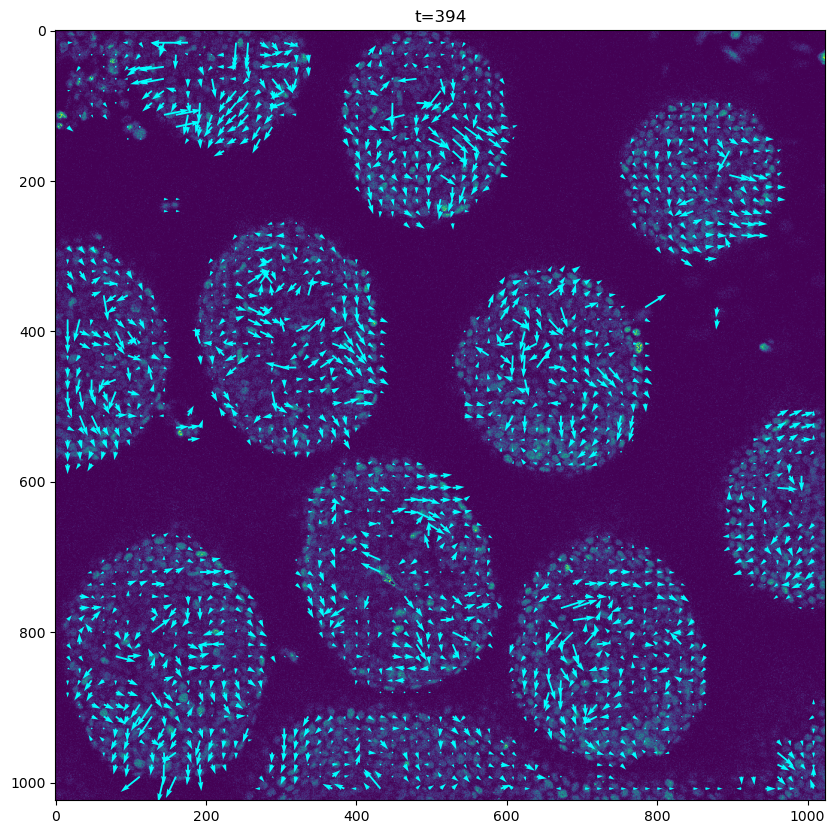

In [5]:
fig = PyPlot.figure(figsize=(10, 10))

function make_frame(i)
    
    PyPlot.clf()
    
    # Taking images.
    img1 = slices[:, :, i+1]
    img2 = slices[:, :, i+2]
    
    # Multiscale Mask.
    out = multiscale_multistep_filter( Float32.( img1 ), grid_sizes=grid_sizes, scales=scales, steps=steps )
    mask = out .> ( img1 .+ Δ_low ) .^ α
    
    # Running PIV.
    VF, _ = multi_quickPIV.PIV( img1, img2, mask, pivparams, precision=32 )
    
    U = VF[ 1, :, : ]; 
    V = VF[ 2, :, : ]; 
    M = sqrt.( U .^ 2 .+ V .^ 2 )
    
    # Postprocessing 
    masked_M = postprocess(M)
    
    U[ masked_M .== 0 ] .= NaN
    V[ masked_M .== 0 ] .= NaN
    ygrid = [ ( y - 1 )*ST[1] + div( IA[1], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
    xgrid = [ ( x - 1 )*ST[2] + div( IA[2], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
    
    imshow(img1)#, cmap="gray")
    #imshow(mask)
    PyPlot.title("t=$(i+1)")
    PyPlot.quiver( xgrid, ygrid, V, -U, color="aqua", scale=150)
    
end
    
myanim = anim.FuncAnimation(fig, make_frame, frames=size(slices,3)-1, 
                            interval=500)
myanim[:save]("headon_2_v1_32.gif", writer="pillow")

hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 


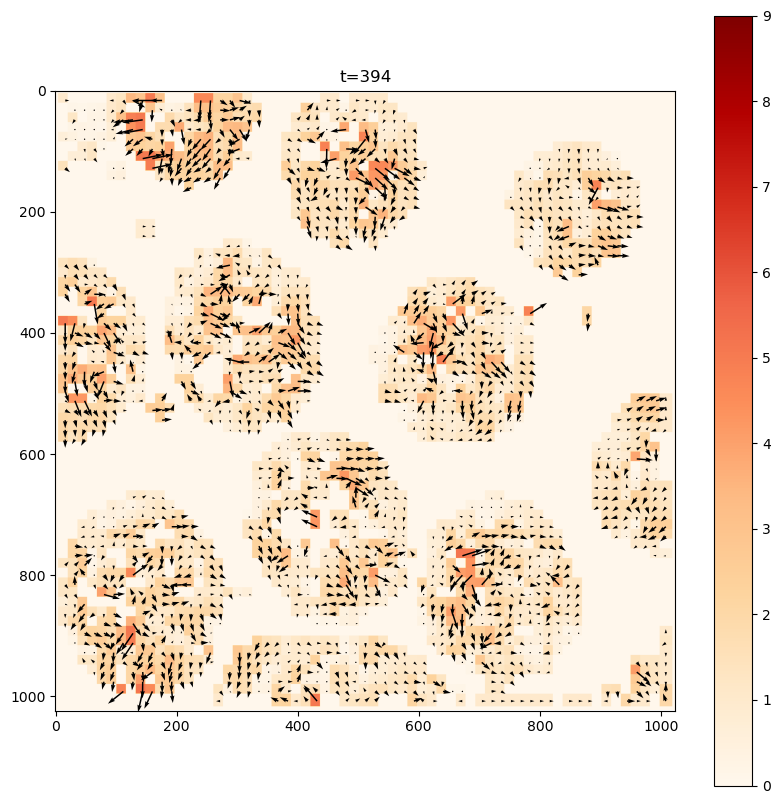

In [4]:
fig_vel = PyPlot.figure(figsize=(10, 10))

function make_frame_vel(i)
    
    PyPlot.clf()
    
    # Taking images.
    img1 = slices[:, :, i+1]
    img2 = slices[:, :, i+2]
    
    # Multiscale Mask.
    out = multiscale_multistep_filter( Float32.( img1 ), grid_sizes=grid_sizes, scales=scales, steps=steps )
    mask = out .> ( img1 .+ Δ_low ) .^ α
    
    # Running PIV.
    VF, _ = multi_quickPIV.PIV( img1, img2, mask, pivparams, precision=32 )
    
    U = VF[ 1, :, : ]; 
    V = VF[ 2, :, : ]; 
    M = sqrt.( U .^ 2 .+ V .^ 2 )
    
    # Postprocessing 
    masked_M = postprocess(M)
    
    U[masked_M .== 0] .= NaN
    V[masked_M .== 0] .= NaN
    ygrid = [ ( y - 1 )*ST[1] + div( IA[1], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
    xgrid = [ ( x - 1 )*ST[2] + div( IA[2], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
    
    V_mask = zeros(size(img1, 1), size(img1, 2))

    for m in 1:size(xgrid,1)
        for n in 1:size(xgrid,2)
            x = xgrid[m, n]
            y = ygrid[m, n]
            V_mask[y-10:y+10, x-10:x+10] .= masked_M[m, n]
        end
    end   
    
    PyPlot.title("t=$(i+1)")
    PyPlot.imshow(V_mask, cmap="OrRd")
    PyPlot.colorbar()
    PyPlot.clim(0, 9)
    PyPlot.quiver(xgrid, ygrid, V, -U, scale=150, color="black")
    
end

myanim = anim.FuncAnimation(fig_vel, make_frame_vel, frames=size(slices,3)-1, 
                            interval=500)
myanim[:save]("headon_2_1_vel.gif", writer="pillow")

In [5]:
m_U = Matrix{Float32}[]
m_V = Matrix{Float32}[]
m_xgrid = Matrix{Float32}[]
m_ygrid = Matrix{Float32}[]
m_M = Matrix{Float32}[]

for i in 1:size(slices, 3)-1
    
    img1 = slices[:, :, i]
    img2 = slices[:, :, i+1]
    
    # Multiscale Mask.
    out = multiscale_multistep_filter( Float32.( img1 ), grid_sizes=grid_sizes, scales=scales, steps=steps )
    mask = out .> ( img1 .+ Δ_low ) .^ α
    
    # Running PIV.
    VF, _ = multi_quickPIV.PIV( img1, img2, mask, pivparams, precision=32 )
    
    U = VF[ 1, :, : ]; 
    V = VF[ 2, :, : ]; 
    M = sqrt.( U .^ 2 .+ V .^ 2 )
    
    # Postprocessing 
    masked_M = postprocess(M)
    
    U[masked_M .== 0] .= NaN
    V[masked_M .== 0] .= NaN
    ygrid = [ ( y - 1 )*ST[1] + div( IA[1], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
    xgrid = [ ( x - 1 )*ST[2] + div( IA[2], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
    
    push!(m_U, U)
    push!(m_V, V)
    push!(m_xgrid, xgrid)
    push!(m_ygrid, ygrid)
    push!(m_M, masked_M)
end

# Converting dimensions with time.
U_data = reduce((x,y) -> cat(x,y,dims=3), m_U)
V_data = reduce((x,y) -> cat(x,y,dims=3), m_V)
xgrid_data = reduce((x,y) -> cat(x,y,dims=3), m_xgrid)
ygrid_data = reduce((x,y) -> cat(x,y,dims=3), m_ygrid)
M_data = reduce((x,y) -> cat(x,y,dims=3), m_M)

hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 


63×63×394 Array{Float32, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.

In [7]:
# Write the data into h5 files:

h5open("U_matrix", "w") do file
    write(file, "matrix", U_data)
end

h5open("V_matrix", "w") do file
    write(file, "matrix", V_data)
end

h5open("xgrid_matrix", "w") do file
    write(file, "matrix", xgrid_data)
end

h5open("ygrid_matrix", "w") do file
    write(file, "matrix", ygrid_data)
end

h5open("M_matrix", "w") do file
    write(file, "matrix", M_data)
end

In [8]:
function read_h5_matrix(folder_path::String, data_name::String)
    h5open(folder_path, "r") do file
        read(file, data_name)
    end
end

read_h5_matrix (generic function with 1 method)

In [15]:
read_h5_matrix("M_matrix", "matrix")

63×63×394 Array{Float32, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.